# Project

In [365]:
import numpy as np
import pandas as pd
import os

from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('fivethirtyeight')
pd.options.display.max_columns = 100

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

from sklearn.manifold import TSNE
from sklearn.model_selection import KFold

os.chdir('C:/Users/RH/Documents/GeekBrains/DataScience course/Numpy, Pandas, Sklearn/Project')

Очистка и подготовка данных

In [424]:
df_train = pd.read_csv('train.csv', sep = ',', encoding = 'utf8')
df_test = pd.read_csv('test.csv', sep = ',', encoding = 'utf8')

#исправляем орфографическую ошибку
df_train = df_train.rename(columns={"Helthcare_2": "Healthcare_2"}) 
df_test = df_test.rename(columns={"Helthcare_2": "Healthcare_2"})

#заменяем нереалистичные данные
#df_train['HouseYear'].sort_values(ascending=False)
df_train['HouseYear'].replace({4968: 1968}, inplace=True) 

#заменяем буквы на цифры в категориальных переменных
df_train['Ecology_2'].replace({'A': 0, 'B': 1}, inplace=True)
df_train['Ecology_3'].replace({'A': 0, 'B': 1}, inplace=True)
df_train['Shops_2'].replace({'A': 0, 'B': 1}, inplace=True)

df_test['Ecology_2'].replace({'A': 0, 'B': 1}, inplace=True)
df_test['Ecology_3'].replace({'A': 0, 'B': 1}, inplace=True)
df_test['Shops_2'].replace({'A': 0, 'B': 1}, inplace=True)

#удаляем кривые данные
df_train = df_train.drop(df_train[df_train['HouseYear'] == 20052011].index)
df_train = df_train.drop(df_train[df_train['KitchenSquare'] >= 1000].index)
df_train = df_train.drop(df_train[df_train['LifeSquare'] >= 4000].index)
df_train = df_train.drop(df_train[df_train['Square'] >= 250].index)

#заполняем пропуски Healthcare_1
df_train['Healthcare_1'] = np.where(np.isnan(df_train['Healthcare_1']), 
                                    np.mean(df_train['Healthcare_1']), df_train['Healthcare_1'])
df_test['Healthcare_1'] = np.where(np.isnan(df_test['Healthcare_1']), 
                                   np.mean(df_test['Healthcare_1']), df_test['Healthcare_1'])

#заменяем квартиры где 0 комнат или слишком много комнат на медиану
df_train['Rooms'] = np.where((df_train['Rooms'] ==0) | (df_train['Rooms'] >=6), 
                             int(np.median(df_train['Rooms'])), df_train['Rooms'])
df_test['Rooms'] = np.where((df_test['Rooms'] ==0) | (df_test['Rooms'] >6), 
                            int(np.median(df_test['Rooms'])), df_test['Rooms'])

#заменяем квартиры где площадь очень маленькая, на медиану
df_train['Square'] = np.where(df_train['Square'] <= 10, np.median(df_train['Square']), df_train['Square'])
df_test['Square'] = np.where(df_test['Square'] <= 10, np.median(df_test['Square']), df_test['Square'])

#заменяем этажность дома где слишком большая, на медиану
df_train['HouseFloor'] = np.where(df_train['HouseFloor'] >= 75, np.median(df_train['HouseFloor']), df_train['HouseFloor'])
df_test['HouseFloor'] = np.where(df_test['HouseFloor'] >= 75, np.median(df_test['HouseFloor']), df_test['HouseFloor'])
df_test['Floor'] = np.where(df_test['Floor'] >= 75, np.median(df_test['Floor']), df_test['Floor'])

#создаем новую переменную, этаж относительно этажности дома и заменяем там где этаж строго больше этажности, на медиану
df_train['RatioFloor'] = df_train['Floor']/df_train['HouseFloor']
df_test['RatioFloor'] = df_test['Floor']/df_test['HouseFloor']
df_train['RatioFloor'] = np.where(df_train['RatioFloor'] > 1, 
                np.median(df_train['RatioFloor'] <= 1), df_train['RatioFloor'])
df_test['RatioFloor'] = np.where(df_test['RatioFloor'] > 1, 
                np.median(df_test['RatioFloor']<= 1), df_test['RatioFloor'])

df_train['HouseFloor'] = np.round(np.where(df_train['Floor']/df_train['HouseFloor'] > 1, 
                                  df_train['Floor']/df_train['RatioFloor'], df_train['HouseFloor']))
df_test['HouseFloor'] = np.round(np.where(df_test['Floor']/df_test['HouseFloor'] > 1, 
                                  df_test['Floor']/df_test['RatioFloor'], df_test['HouseFloor']))

#создаем доп переменную - одноэтажный дом
df_train['1FloorHouse'] = np.where((df_train['HouseFloor']<=1) & (df_train['Floor']<=1), 1, 0)
df_test['1FloorHouse'] = np.where((df_test['HouseFloor']<=1) & (df_test['Floor']<=1), 1, 0)

#создаем доп переменную - дом от 2 этажей, и живет на 1 этаже
df_train['1Floor'] = np.where((df_train['HouseFloor']>1) & (df_train['Floor']<=1), 1, 0)
df_test['1Floor'] = np.where((df_test['HouseFloor']>1) & (df_test['Floor']<=1), 1, 0)

#заменяем нереалистичные по площади кухни
df_test['KitchenSquare'] = np.where(df_test['KitchenSquare'] >= 200, 
                                    np.median(df_test['KitchenSquare']), df_test['KitchenSquare'])
df_train['KitchenSquare'] = np.where((df_train['KitchenSquare']/df_train['Square']>=0.85) | (df_train['KitchenSquare'] <=3), 
                                     0, df_train['KitchenSquare'])
df_test['KitchenSquare'] = np.where((df_test['KitchenSquare']/df_test['Square']>=0.85) | (df_test['KitchenSquare'] <=3), 
                                    0, df_test['KitchenSquare'])

df_train['KitchenShare'] = df_train['KitchenSquare']/df_train['Square']
df_test['KitchenShare'] = df_test['KitchenSquare']/df_test['Square']

pd.options.mode.chained_assignment = None  # default='warn'
def KitchenShare(data):

    
    for i in range(1, 5):
        ratio = np.median(data['KitchenShare'].loc[(data['Rooms'] == i) & (data['KitchenShare'] != 0)])
        x = data['KitchenSquare'].loc[data['Rooms'] == i]
        y = ratio*data['Square'].loc[data['Rooms'] == i]
        x = np.where(x == 0, y, x)
        data['KitchenSquare'].loc[data['Rooms'] == i] = x
        

    ratio = np.median(data['KitchenShare'].loc[(data['Rooms'] >= 5) & (data['KitchenShare'] != 0)])    
    x = data['KitchenSquare'].loc[data['Rooms'] >= 5]
    y = ratio*data['Square'].loc[data['Rooms'] >= 5]
    x = np.where(x == 0, y, x)
    data['KitchenSquare'].loc[data['Rooms'] >= 5] = x
    
    
KitchenShare(df_train)
KitchenShare(df_test)

df_train['KitchenShare'] = df_train['KitchenSquare']/df_train['Square']
df_test['KitchenShare'] = df_test['KitchenSquare']/df_test['Square']

#df_test['Square'].sort_values(ascending=True).head(10)

In [367]:
#df_train.shape
#df_train.isna().sum()
#df_train.describe
df_train.head(5)

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
0  14038          35    2.0  47.981561   29.442751       6.000000      7   
1  15053          41    3.0  65.683640   40.049543       8.000000      7   
2   4765          53    2.0  44.947953   29.197612       6.393649      8   
3   5809          58    2.0  53.352981   52.731512       9.000000      8   
4  10783          99    1.0  39.649192   23.776169       7.000000     11   

   HouseFloor  HouseYear  Ecology_1  Ecology_2  Ecology_3  Social_1  Social_2  \
0         9.0       1969   0.089040          1          1        33      7976   
1         9.0       1978   0.000070          1          1        46     10309   
2        12.0       1968   0.049637          1          1        34      7759   
3        17.0       1977   0.437885          1          1        23      5735   
4        12.0       1976   0.012339          1          1        35      5776   

   Social_3  Healthcare_1  Healthcare_2  Shops_1  Shops_2          Price  \
0         5   1142.839299             0       11        1  184966.930730   
1         1    240.000000             1       16        1  300009.450063   
2         0    229.000000             1        3        1  220925.908524   
3         3   1084.000000             0        5        1  175616.227217   
4         1   2078.000000             2        4        1  150226.531644   

   KitchenShare  1FloorHouse  1Floor  Studio  RatioFloor  
0      0.125048            0       0       0    0.777778  
1      0.121796            0       0       0    0.777778  
2      0.142246            0       0       0    0.666667  
3      0.168688            0       0       0    0.470588  
4      0.176548            0       0       0    0.916667

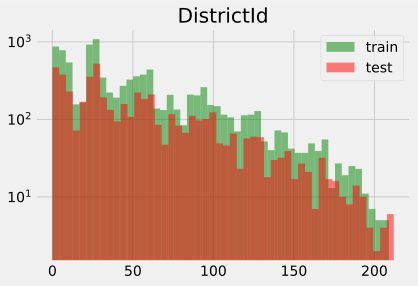

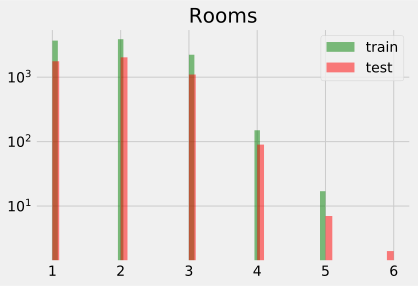

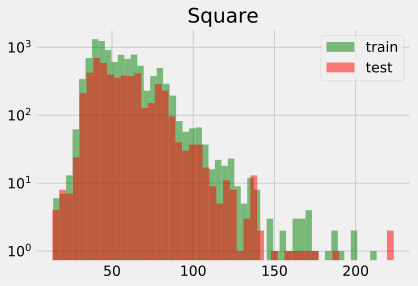

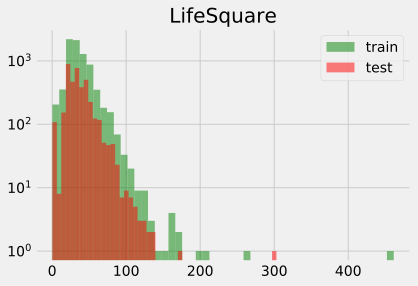

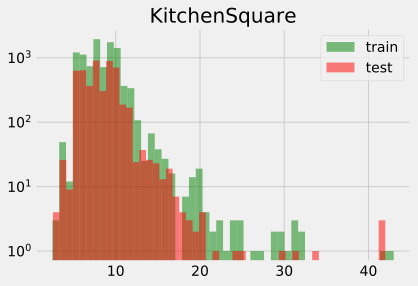

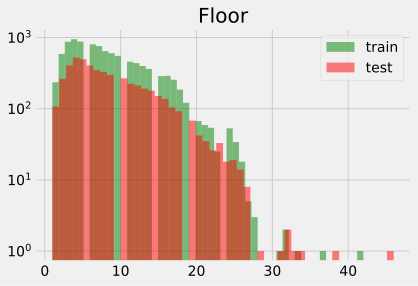

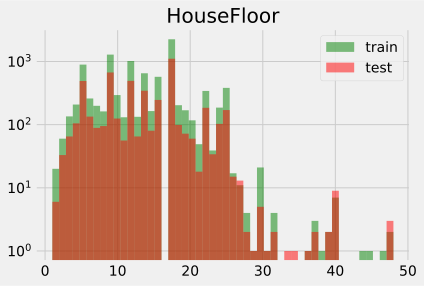

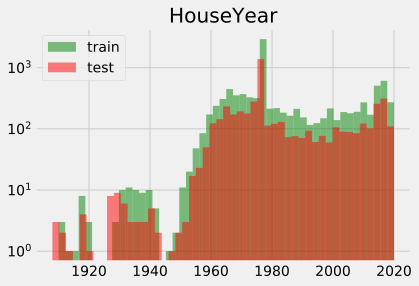

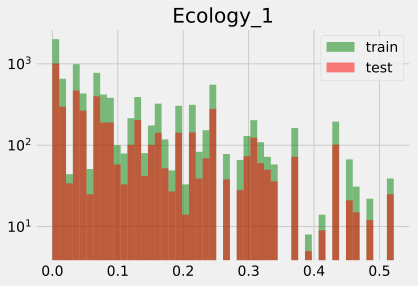

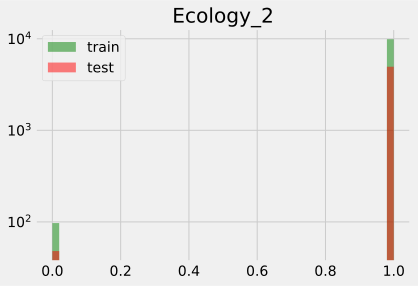

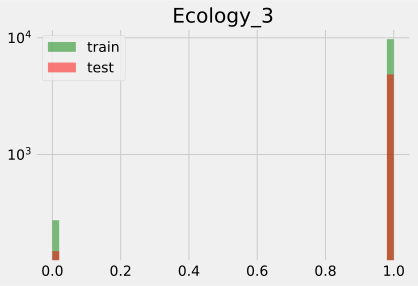

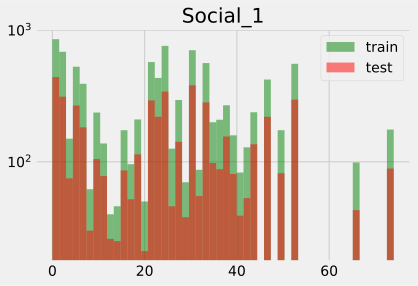

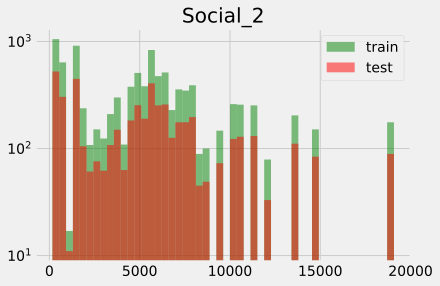

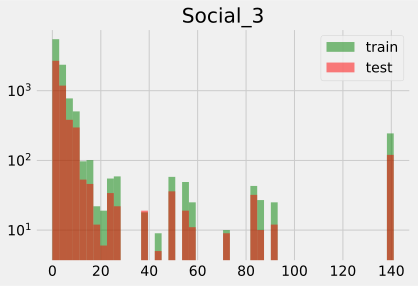

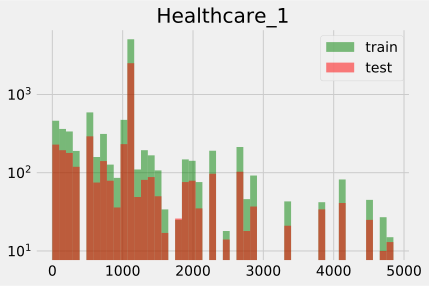

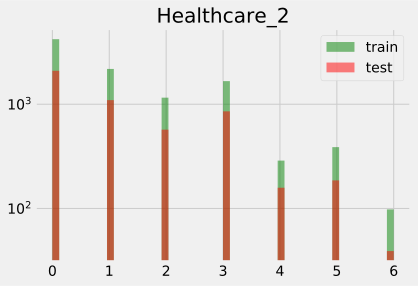

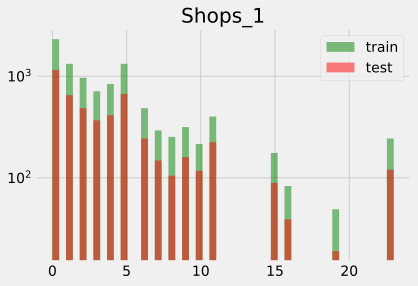

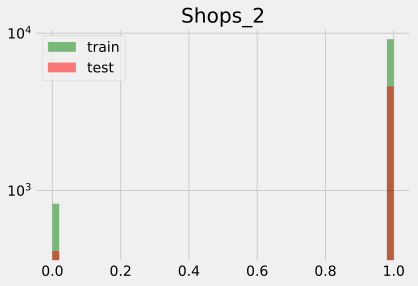

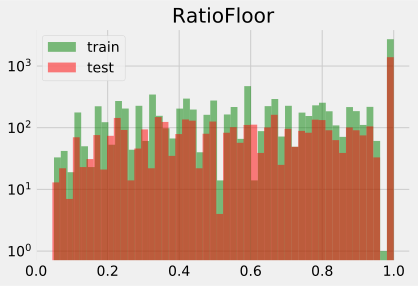

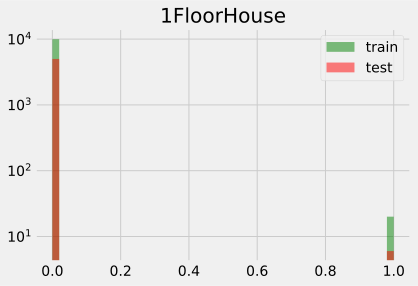

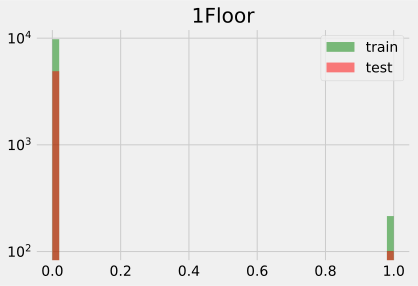

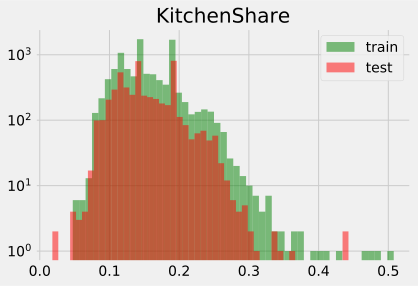

In [429]:
def compare(feature):

    plt.hist(df_train[feature], bins=50, alpha  = 0.5, color = 'green', label='train')
    plt.hist(df_test[feature], bins=50, alpha  = 0.5, color = 'red', label='test')
    plt.title(feature)
    plt.legend()
    plt.yscale('log')
    plt.show()

for i in range(1, len(df_test.columns)):
    compare(df_test.columns[i])

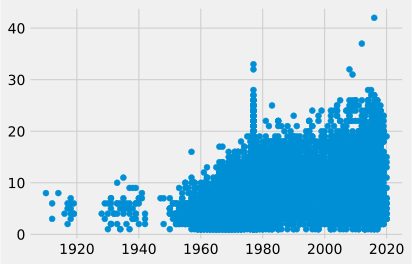

In [434]:
plt.scatter(df_train['HouseYear'], df_train['Floor'])
plt.show()

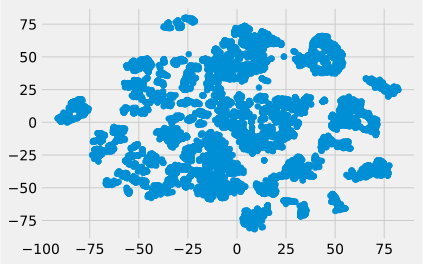

In [136]:

# , 'Shops_2' 'Ecology_2', 'Ecology_3',
features = ['Square', 'Floor', 'Rooms', 'HouseYear', 'Ecology_1',  'Social_1', 'Social_2', 'Social_2', 
         'Healthcare_2', 'Shops_1']

x_sc = scaler.fit(df_train[features].values)
x_train_sc = x_sc.transform(df_train[features].values)

tsne = TSNE(n_components=2, perplexity = 45, learning_rate=150, random_state=100)
x_train_tsne = tsne.fit_transform(x_train_sc)

plt.scatter(x_train_tsne[:, 0], x_train_tsne[:, 1])
plt.show()

In [230]:


"""
#df_train['Ecology_2'] = df_train['Ecology_2'].astype('category')
#df_train['Ecology_3'] = df_train['Ecology_3'].astype('category')
#df_train['Shops_2'] = df_train['Shops_2'].astype('category')


category = ['Ecology_2', 'Ecology_3', 'Shops_2']


from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()

x_ohe = ohe.fit(df_train[category])
x_ohe.categories_
x_ohe.get_feature_names(['Ecology_2', 'Ecology_3', 'Shops_2'])
x_train_ohe = x_ohe.transform(df_train[category]).toarray() 

#concatenated_data = pd.concat([df_train, x_train_ohe], axis=1)
x_train_ohe = pd.DataFrame(x_train_ohe, index=df_train.index, 
                           columns = x_ohe.get_feature_names(['Ecology_2', 'Ecology_3', 'Shops_2']))
x_train_ohe.head(5)
"""


"\n#df_train['Ecology_2'] = df_train['Ecology_2'].astype('category')\n#df_train['Ecology_3'] = df_train['Ecology_3'].astype('category')\n#df_train['Shops_2'] = df_train['Shops_2'].astype('category')\n\n\ncategory = ['Ecology_2', 'Ecology_3', 'Shops_2']\n\n\nfrom sklearn.preprocessing import OneHotEncoder\nohe = OneHotEncoder()\n\nx_ohe = ohe.fit(df_train[category])\nx_ohe.categories_\nx_ohe.get_feature_names(['Ecology_2', 'Ecology_3', 'Shops_2'])\nx_train_ohe = x_ohe.transform(df_train[category]).toarray() \n\n#concatenated_data = pd.concat([df_train, x_train_ohe], axis=1)\nx_train_ohe = pd.DataFrame(x_train_ohe, index=df_train.index, \n                           columns = x_ohe.get_feature_names(['Ecology_2', 'Ecology_3', 'Shops_2']))\nx_train_ohe.head(5)\n"

Подготовка модели

In [432]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

target = 'Price'
# , 'Shops_2', 'Ecology_2', 'Ecology_3', '1FloorHouse', '1Floor',
features = ['DistrictId', 'Square',  'KitchenSquare', 'Floor', 'Rooms', 'HouseYear', 'Ecology_1', 
            'Social_1', 'Social_2', 'Social_2', 'Healthcare_1', 'Healthcare_2', 'Shops_1',  
            'RatioFloor', 'HouseFloor', 'KitchenShare']

y = df_train[target].values.ravel()
x = df_train[features].values

param_grid  = {'max_depth':[16, 17, 18, 19, 20, 21, 22],
                'min_samples_split':[2],
                'min_samples_leaf':[1],
              'n_estimators':[300]}

rf = RandomForestRegressor(  criterion='mse',                           
                             min_weight_fraction_leaf=0.0,
                             max_leaf_nodes=None,
                             min_impurity_decrease=0.0,
                             min_impurity_split=None,
                             bootstrap=True,
                             oob_score=False,
                             random_state=1,
                             verbose=0,
                             warm_start=False)

grid = GridSearchCV(rf, param_grid = param_grid, cv = 10, 
                    scoring = 'r2') 

grid.fit(x, y)

print(grid.best_estimator_)

print(grid.best_score_)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=22,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=300,
                      n_jobs=None, oob_score=False, random_state=1, verbose=0,
                      warm_start=False)
0.7317281232105726


In [435]:
model = grid.best_estimator_.fit(x, y)
feach_import = np.vstack((features, np.round(model.feature_importances_,2))).T
feach_import

array([['DistrictId', '0.06'],
       ['Square', '0.39'],
       ['KitchenSquare', '0.02'],
       ['Floor', '0.02'],
       ['Rooms', '0.08'],
       ['HouseYear', '0.04'],
       ['Ecology_1', '0.04'],
       ['Social_1', '0.1'],
       ['Social_2', '0.05'],
       ['Social_2', '0.06'],
       ['Healthcare_1', '0.04'],
       ['Healthcare_2', '0.01'],
       ['Shops_1', '0.02'],
       ['RatioFloor', '0.02'],
       ['HouseFloor', '0.03'],
       ['KitchenShare', '0.03']], dtype='<U32')

Прогноз

In [436]:
x_test = df_test[features].values
y_test = np.round(model.predict(x_test),1)

output = np.vstack([df_test['Id'].values, y_test]).T

output = pd.DataFrame(output)
output.columns = ['Id', 'Price']
output['Id'] = pd.to_numeric(output['Id'], downcast='integer')

output.to_csv('output.csv', index=False, sep= ',')

In [104]:
train_room_stat = df_train.groupby(['Rooms']).agg({'Square':['count', 'mean', 'min', 'max']})
train_room_stat

Square                                   
       count        mean        min         max
Rooms                                          
1.0     3701   41.225797   1.136859  174.649522
2.0     3890   56.546738   2.377248  212.932361
3.0     2234   76.901089   4.390331  190.857689
4.0      150   98.377544  44.128947  200.334539
5.0       17  113.613157  39.906082  198.930182

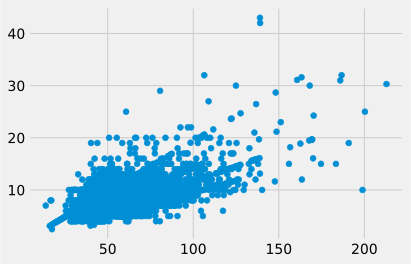

In [406]:
plt.scatter(df_train['Square'], df_train['KitchenSquare'])
plt.show()

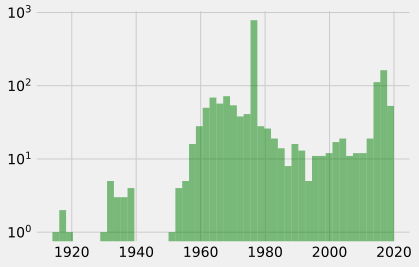

In [359]:
z = df_train.loc[df_train['Floor'] > df_train['HouseFloor']]
plt.hist(z['HouseYear'], bins=50, alpha  = 0.5, color = 'green', label='train')
plt.yscale('log')
plt.show()

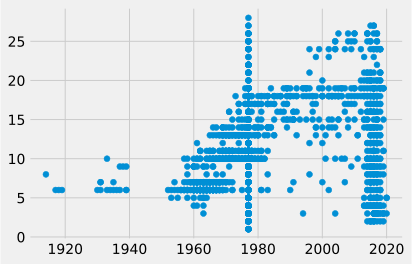

In [360]:
z = df_train.loc[df_train['Floor'] > df_train['HouseFloor']]
plt.scatter(z['HouseYear'], z['Floor'])
plt.show()

In [412]:
df_train['HouseFloor'].loc[df_train['HouseFloor'] == 0].count()

269